In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
file_path = r"C:\Users\james\J_Data_Lab\Project_subway\data\df_subway_prep2.csv"
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571731 entries, 0 to 5571730
Data columns (total 49 columns):
 #   Column          Dtype  
---  ------          -----  
 0   년도              int64  
 1   분기              int64  
 2   수송연월            object 
 3   날짜              object 
 4   요일구분            object 
 5   공휴일 여부          int64  
 6   호선명             int64  
 7   역명              object 
 8   시간              object 
 9   승차인원            int64  
 10  하차인원            int64  
 11  우대권인원수          int64  
 12  청소년인원수          int64  
 13  기온(°C)          float64
 14  강수량(mm)         float64
 15  풍속(m/s)         float64
 16  습도(%)           int64  
 17  적설(cm)          float64
 18  승하차인원           int64  
 19  출입구             int64  
 20  섬식여부            int64  
 21  환승노선_개수         int64  
 22  면적              float64
 23  수송인원수           float64
 24  환승유입인원수         float64
 25  상선 혼잡도          float64
 26  하선 혼잡도          float64
 27  승강장혼잡도1         float64
 28  승강장혼잡도2     

In [16]:
df

,년도,분기,수송연월,날짜,요일구분,공휴일 여부,호선명,역명,시간,승차인원,...,서울_인구(천명),서울_인구밀도,수도권_인구(천명),수도권_인구밀도,승하차인원 대비 서울인구,승하차인원 대비 수도권인구,자동차등록대수(만대),기준금리,한국CPI,CPI_대비_지하철요금
0,2021,1,2021-01,2021-01-01,평일,1,1,동대문,05:00,59,...,9508,15709,26069,2196,0.000008,0.000003,2491,0.5,0.6,2083.333333
1,2021,1,2021-01,2021-01-01,평일,1,1,동대문,06:00,67,...,9508,15709,26069,2196,0.000013,0.000005,2491,0.5,0.6,2083.333333
2,2021,1,2021-01,2021-01-01,평일,1,1,동대문,07:00,87,...,9508,15709,26069,2196,0.000016,0.000006,2491,0.5,0.6,2083.333333
3,2021,1,2021-01,2021-01-01,평일,1,1,동대문,08:00,121,...,9508,15709,26069,2196,0.000022,0.000008,2491,0.5,0.6,2083.333333
4,2021,1,2021-01,2021-01-01,평일,1,1,동대문,09:00,173,...,9508,15709,26069,2196,0.000031,0.000011,2491,0.5,0.6,2083.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571726,2023,4,2023-12,2023-12-31,일요일,0,8,천호,19:00,535,...,9400,15533,26190,2206,0.000128,0.000046,2595,3.5,3.2,437.500000
5571727,2023,4,2023-12,2023-12-31,일요일,0,8,천호,20:00,492,...,9400,15533,26190,2206,0.000122,0.000044,2595,3.5,3.2,437.500000
5571728,2023,4,2023-12,2023-12-31,일요일,0,8,천호,21:00,394,...,9400,15533,26190,2206,0.000100,0.000036,2595,3.5,3.2,437.500000
5571729,2023,4,2023-12,2023-12-31,일요일,0,8,천호,22:00,307,...,9400,15533,26190,2206,0.000096,0.000034,2595,3.5,3.2,437.500000


In [4]:
# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # 결측치 0으로 대체
    df.fillna(0, inplace=True)
    
    # **서울역 데이터만 선택**
    df = df[df['역명'] == '서울역'].reset_index(drop=True)
    
    # '날짜'를 datetime으로 변환
    df['날짜'] = pd.to_datetime(df['날짜'])
    
    # '요일구분'을 숫자형으로 변환
    weekday_mapping = {'평일': 0, '토요일': 1, '일요일': 2}
    df['요일구분'] = df['요일구분'].map(weekday_mapping)
    
    # '시간'을 숫자형으로 변환 (시간대만 추출하여 정수형으로 변환)
    df['시간'] = df['시간'].str.split(':').str[0].astype(int)
    
    # '역명'을 Label Encoding
    le_station = LabelEncoder()
    df['역명'] = le_station.fit_transform(df['역명'])
    
    # '날짜'부터 시작하는 변수 선택
    columns = df.columns.tolist()
    start_index = columns.index('날짜')
    selected_columns = columns[start_index:]
    
    # 제외할 변수 지정
    excluded_columns = ['승하차인원', '면적', '승강장혼잡도2', '승강장혼잡도1', '날짜', '년도', '분기', '수송연월','승하차인원차','승하차인원 대비 서울인구'
                        ,'승하차인원 대비 수도권인구']
    feature_columns = [col for col in selected_columns if col not in excluded_columns]
    
    # 독립 변수와 종속 변수 분리
    X = df[feature_columns]
    y = df['승강장혼잡도1']
    
    # 남아있는 object 타입의 변수 처리 (Label Encoding)
    object_cols = X.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        for col in object_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
    
    # 학습용과 검증용 데이터로 분할
    X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # 결과를 딕셔너리 형태로 반환
    data = {
        'X_train_scaled': X_train_scaled,
        'Y_train': Y_train,
        'X_val_scaled': X_val_scaled,
        'Y_val': Y_val,
        'train_data': X_train,
        'val_data': X_val
    }
    return data


In [5]:
def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred, model_name):
    plt.figure(figsize=(14, 6))

    # 학습 데이터 결과 (직선)
    plt.subplot(1, 2, 1)
    plt.plot(Y_train, Y_train_pred, 'b-', linewidth=2, label='예측 값')
    plt.plot(Y_train, Y_train, 'r--', linewidth=2, label='실제 값')  # 실제 값을 나타내는 대각선
    plt.xlabel('실제 값')
    plt.ylabel('예측 값')
    plt.title(f'{model_name} - 학습 데이터')
    plt.legend()

    # 검증 데이터 결과 (직선)
    plt.subplot(1, 2, 2)
    plt.plot(Y_val, Y_val_pred, 'orange', linewidth=2, label='예측 값')
    plt.plot(Y_val, Y_val, 'r--', linewidth=2, label='실제 값')  # 실제 값을 나타내는 대각선
    plt.xlabel('실제 값')
    plt.ylabel('예측 값')
    plt.title(f'{model_name} - 검증 데이터')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [6]:
#랜덤포레스트
def model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.uniform('max_features', 0.1, 1.0),
        'bootstrap': hp.choice('bootstrap', [True, False])
    }

    def objective(space):
        clf = RandomForestRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            min_samples_split=int(space['min_samples_split']),
            min_samples_leaf=int(space['min_samples_leaf']),
            max_features=space['max_features'],
            bootstrap=space['bootstrap'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = RandomForestRegressor(
    n_estimators=int(best_hyperparams['n_estimators']),
    max_depth=int(best_hyperparams['max_depth']),
    min_samples_split=int(best_hyperparams['min_samples_split']),
    min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
    max_features=best_hyperparams['max_features'],
    bootstrap=bool(best_hyperparams['bootstrap']),  # 여기에서 bool로 변환
    random_state=0
)





    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#XGB
def model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1.0)
    }

    def objective(space):
        clf = xgb.XGBRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            gamma=space['gamma'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = xgb.XGBRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        learning_rate=best_hyperparams['learning_rate'],
        subsample=best_hyperparams['subsample'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results
    
# LightGBM 모델 함수 
def model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
        'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1.0)
    }

    def objective(space):
        clf = lgb.LGBMRegressor(
            num_leaves=int(space['num_leaves']),
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            n_estimators=int(space['n_estimators']),
            min_child_weight=space['min_child_weight'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = lgb.LGBMRegressor(
        num_leaves=int(best_hyperparams['num_leaves']),
        max_depth=int(best_hyperparams['max_depth']),
        learning_rate=best_hyperparams['learning_rate'],
        n_estimators=int(best_hyperparams['n_estimators']),
        min_child_weight=best_hyperparams['min_child_weight'],
        subsample=best_hyperparams['subsample'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

In [7]:
#file_path = r"C:\Users\james\J_Data_Lab\Project_subway\data\df_subway_prep2.csv"
data = preprocess_data(file_path)

X_train_scaled = data['X_train_scaled']
Y_train = data['Y_train']
X_val_scaled = data['X_val_scaled']
Y_val = data['Y_val']
train_data = data['train_data']
val_data = data['val_data']



--- XGBoost 모델 학습 및 평가 ---

100%|████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.20trial/s, best loss: 0.2498080101426363]
XGBoost 모델의 최적 하이퍼파라미터:
{'colsample_bytree': 0.9745271045382071, 'gamma': 0.4171573842730001, 'learning_rate': 0.041726763372336294, 'max_depth': 13.0, 'n_estimators': 250.0, 'reg_alpha': 0.3286012353302997, 'reg_lambda': 0.2681871215457146, 'subsample': 0.9122799807592396}
XGBoost(Train):
R-squared: 1.0000
MAE: 0.1168
MSE: 0.0302
MAPE: 0.57%

XGBoost(Validation):
R-squared: 0.9996
MAE: 0.2498
MSE: 0.3604
MAPE: 0.74%


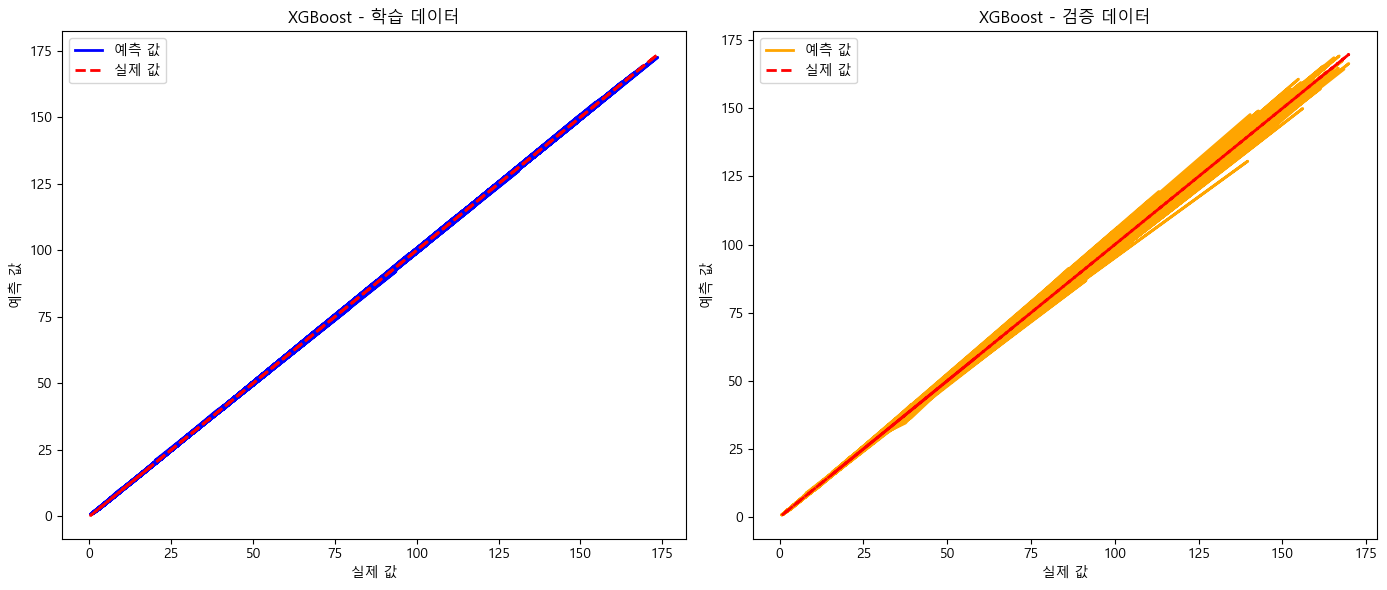

In [8]:
# 모델별로 학습 및 평가 수행
models = {
   # 'Random Forest': model_rf,
    'XGBoost': model_xgb
   #,'LightGBM': model_lightgbm
}

for model_name, model_func in models.items():
    print(f'\n\n--- {model_name} 모델 학습 및 평가 ---\n')
    
    best_model, results = model_func(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=50)
    
    if 'best_hyperparams' in results:
        print(f"{model_name} 모델의 최적 하이퍼파라미터:")
        print(results['best_hyperparams'])
    
    print(f'{model_name}(Train):')
    print(f"R-squared: {results['train_metrics']['r_squared']:.4f}")
    print(f"MAE: {results['train_metrics']['mae']:.4f}")
    print(f"MSE: {results['train_metrics']['mse']:.4f}")
    print(f"MAPE: {results['train_metrics']['mape']:.2f}%")
    print()
    print(f'{model_name}(Validation):')
    print(f"R-squared: {results['val_metrics']['r_squared']:.4f}")
    print(f"MAE: {results['val_metrics']['mae']:.4f}")
    print(f"MSE: {results['val_metrics']['mse']:.4f}")
    print(f"MAPE: {results['val_metrics']['mape']:.2f}%")
    
    Y_train_pred = best_model.predict(X_train_scaled)
    Y_val_pred = best_model.predict(X_val_scaled)
    
    plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred, model_name)